## Modeling Steps:

   1. Map sentence from  `text` column into word embeddings and **average** the embeddings into 1`word_embed` vector.

   2. Cluster all `word_embed`  vectors using any clustering algorithms.

   3. Map each word from `keywords` to `label_embed ` vector.

      **Negative samples for negative labels**

   4. Concatenate them `concat(word_embed, label_embed)`

   5. Feed into dense layer(s)

In [1]:
import sys, os
import re  
import collections
import numpy as np
import pandas as pd 
from pandas import DataFrame, Series
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use('ggplot')
# from matplotlib.ticker import MaxNLocator # used to force yticks to assume integer values

from utils import highlight
from data_pipeline import transform_documents, load_document_vectors, load_document_concept_vectors

# set random state seed for reproducibility 
# np.random.seed(53)

In [2]:
from data_pipeline import load_data, fraction_rows_missing

df = load_data(subset=False, verbose=True)

> size(df): 381988 -> 381988; dropped 0 rows
(load_data) Dim(df): (381988, 3)


In [3]:
df.head()

,text,keywords,cluster_id
0,There Were 2 Mass Shootings In Texas Last Week...,"['mass', 'week', 'shootings', 'texas', 'crime']",3
1,Will Smith Joins Diplo And Nicky Jam For The 2...,"['world', 'song', 'smith', 'joins', 'diplo', '...",3
2,Hugh Grant Marries For The First Time At Age 57,"['age', 'grant', 'marries', 'time', 'hugh', 'e...",7
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,"['castrato', 'blasts', 'adam', 'artwork', 'car...",1
4,Julianna Margulies Uses Donald Trump Poop Bags...,"['dog', 'margulies', 'donald', 'trump', 'poop'...",2


### Step 0: Explorary Data Analysis 

The `data_pipeline` module defines the utility functions for EDA and train data preparation.

- It is uncertain if Google News w2v was prepared with stemming or more advanced text processing like lemmatization. To verify this, we can check the ratio of known embeddings by applying stemming to `text` column. It turns out that applying stemming reduces the number of embeddings found from the pre-trained model. 

In [4]:
from data_pipeline import verify_pretrained_w2v

# Examine pre-trained word embeddings 
# Note: I used 'texts' to refer to news headlines defined in data_news.csv 
#       and 'concepts' to refer to the set of their associated keywords
verify_pretrained_w2v(verify_texts=True, verify_concepts=True)

> size(df): 381988 -> 381988; dropped 0 rows
(load_data) Dim(df): (381988, 3)
Stemming applied? No ...
... Found N=153573 unique tokens. Average 'hit' ratio per text: 0.9202011604594252
...... Among N=153573 tokens, n=104066 of them has known embedding.
...... Max: 177, Min: 0, Median: 11.0, n(Empty): 6
Stemming applied? Yes ...
... Found N=90291 unique tokens. Average 'hit' ratio per text: 0.7643262692434042
...... Among N=90291 tokens, n=20955 of them has known embedding.
...... Max: 177, Min: 0, Median: 11.0, n(Empty): 6
... Found N=82272 unique concepts. Average 'hit' ratio per concept list: 0.8983321465595778
... Among N=82272 concepts, n=45034 of them has known embedding.
...... Max: 6, Min: 1, Median: 6.0, n(Empty): 0
Most enriched concepts:
[('politics', 62885), ('wellness', 35831), ('entertainment', 29686), ('travel', 20833), ('style & beauty', 19286), ('parenting', 18150), ('trump', 13590), ('food & drink', 12443), ('business', 12205), ('healthy living', 11959)]

...      lea

### Step 1: Computing Doc2Vec

- Compute doc2vec for each news headline (`text`) by taking the average of its word vectors
  - `data_pipeline` is the module that defines related functions that transform text data into vector representations
  - In particular, `make_document_training_set()` generates document embeddings for cluster analysis
- Please see `run_data_pipeline()` within `data_pipeline` for related demos including data preparation for cluster analysis and for the zero-shot text classification

In [ ]:
from data_pipeline import transform_documents, load_document_vectors 
# Prepare document vectors (this will take a while)

highlight("1. Create document vectors for clustering ...")
transform_documents(input_file='news_data.csv', 
               pretrained_w2v="GoogleNews-vectors-negative300.bin", 
               save=True, test=test_mode)
X, _ = load_document_vectors(data_index=0, test=False)  
print(f"> dim(X): {X.shape}")  

### Step 2: Cluster Analysis

- The following demo function `model.cluster_document_vectors()` applies selected clustering algorithms (e.g. PCA followed by K-means, HDBSCAN) to the document vectors given in Step 1

- The clustering-related subroutines are defined in the following modules: 
  - `cluster.py`: primary module for cluster analysis
  - `cluster_utils.py`
  - `learn_manifold.py`
  
- Considering the large sample size (~2.5M) and relatively high dimensionality of the embedding space, we will apply PCA first to reduce the dimensionality of the data prior to running either k-means or minibatch kmeans. 
  - Alternatively, use density-based clustering approach. [Hierarhical DBSCAN or HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan) is a potential approach that does not rely on the problematic euclidean distance in high-D space. 
- See also `cluster.cluster_analysis()` for various cluster evaluation metrics. 

- Optionally, use T-SNE to embed a subset of the document vectors to the 2D space and observe if there exist distinct cluster structures.
- Optionally, take a relatively smaller sample (say, n=2000) and apply spectral clustering using RBF kernel. Spectral clustering would have been more robust for high dimensional data compared to k-means; however it is computationally expensive and potentially intractable with a large sample size. 
- Also see `cluster.py` for related demos.

> size(df): 381988 -> 381988; dropped 0 rows
(load_data) Dim(df): (381988, 3)
> dim(X): (381988, 300)
Running PCA followed by K-Means on n=381988 document vectors of dimension 300 ...
(cluster_analysis) Method: k-means, Input shape: (381988, 10))
... # of clusters requested: 10, # of classes: 1 (1 if `y` is unknown)
... n_clusters obtained: 10 =?= n_clusters expected: 10
[I/O] Saving cluster map (id -> cluster id) to /Users/pleiadian53/work/interview/Happify/happify_interview_2/output/cluster_id-zero-shot-Ck-means-nC10.csv
[I/O] Saving knn-to-centriod map (cid -> knn wrt centroid) to /Users/pleiadian53/work/interview/Happify/happify_interview_2/output/cluster_knnmap-zero-shot-Ck-means-nC10.csv
(demo) Saving cluster IDs to news_data.csv
Running T-SNE on a subset of the data (n=2000) ...
[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 1000 / 

<Figure size 432x288 with 0 Axes>

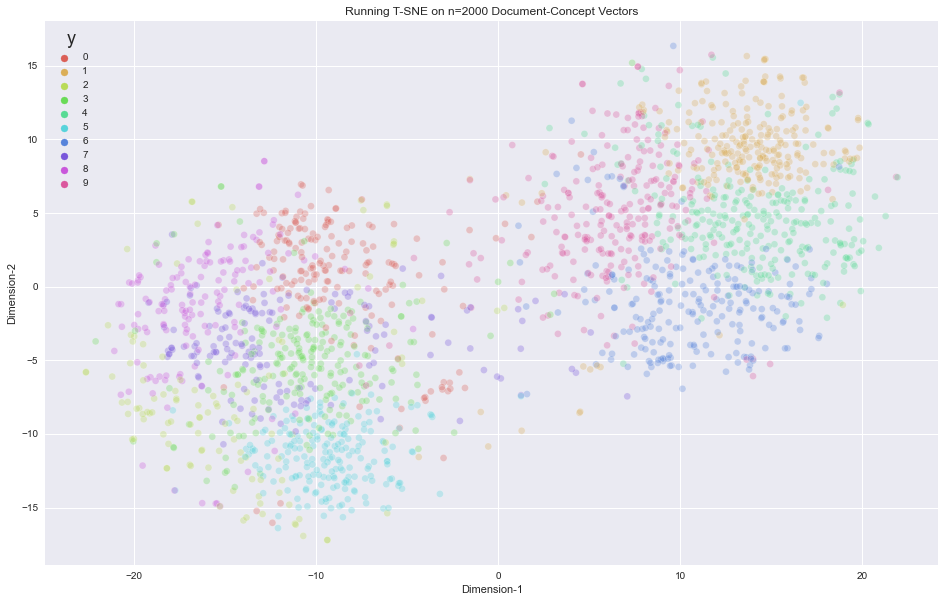

(saveFig) Saving plot to:
/Users/pleiadian53/work/interview/Happify/happify_interview_2/output/document_clusters-tsne.tif
... description: n/a
Estimate # of clusters via eigengap and run spectral clustering accordingly (n=2000) ...
[output] saving cluster distribution to:
/Users/pleiadian53/work/interview/Happify/happify_interview_2/output/eigendecom-K5.tif

... Optimal number of clusters [1 2 3 4 6]
(cluster_analysis) Method: spectral, Input shape: (2000, 300))
... # of clusters requested: 6, # of classes: 1 (1 if `y` is unknown)
... n_clusters obtained: 6 =?= n_clusters expected: 6
[I/O] Saving cluster map (id -> cluster id) to /Users/pleiadian53/work/interview/Happify/happify_interview_2/output/cluster_id-zero-shot-Cspectral-nC6.csv
[I/O] Saving knn-to-centriod map (cid -> knn wrt centroid) to /Users/pleiadian53/work/interview/Happify/happify_interview_2/output/cluster_knnmap-zero-shot-Cspectral-nC6.csv


/Users/pleiadian53/miniforge3/envs/apple_tensorflow/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


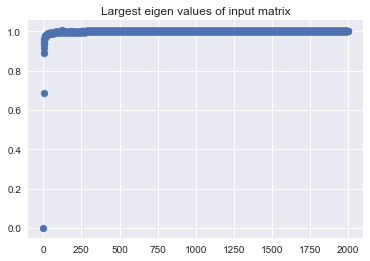

In [7]:
from model import cluster_document_vectors
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# An example clustering pipeline 
cluster_document_vectors(input_file='news_data.csv', 
                         n_samples=None) # set n_samples to a desired sample size

# Note that running clustering on large sample size would take a long time; set n_samples to a desired sample size
# to speed it up

### Step 3 & 4: Generating Document-Concept Vectors

- For ease of exposition, we shall consider each news headline in `text` column as a **document** and each keyword (in `keywords` column) as a **concept**
- `transform_documents_and_concepts()` in `data_pipeline` is the function that generates document-concept vectors for the classification task
  - As mentioned in the [paper: "Zero-Shot Learning for Text Classification"](https://arxiv.org/abs/1712.05972), the zero-shot text classification is formulated by a binary classification problem that attempts to predict if a text/document and a concept/keyword is related or not
  - Positive examples: Each possible pairing between a document and its related concept is a positive example; hence, if a document is connection to N keywords (hence N concepts), then we have N positive examples for that document (each document is associated with at most 6 keywords in `news_data.csv`)
  - Negative examples: Each pairing between a document and its concept that does NOT appear in the N keywords is considered a valid negative example. If a document is associated with N positive examples, then we also match them with an equal amount of negative examples. As a result of this simple negative sampling approach, the class distribution is perfectly balanced with 50% positives and 50% negatives.  
  - `transform_documents_and_concepts()` generates both *a training split* and *a test split*, where **the test set is associated with only the concepts/keywords that did not appear in the training split.** This is to verify that the learned model can be generalized to unseen concepts/keywords. 
  
- Alternatively, we could create our own data generator to deliver document vectors and concept vectors separately and concatenate them on the fly from within the DNN (i.e. a two-input branching dense network) but doing so may slow down the training process (therefore, the training data is pre-computed before feed it to the DNN).

Note: The following code block will take time (30+ mins on Apple M1 with 16G memory); it generates document-concept vectors for classification

In [ ]:
from data_pipeline import transform_documents_and_concepts, load_document_concept_vectors

highlight("[test] 2. Create document-concept vectors for (concept) classification ...")
transform_documents_and_concepts(input_file='news_data.csv', 
               pretrained_w2v="GoogleNews-vectors-negative300.bin",   
               train_size=0.6, save=True,

               n_samples=None, # None to include all documents, or set it to a desired number of documents  
               full_positive_set=True, # Set to True to include ALL keywords in making positive examples 
               test=False)

X_train, X_test, y_train, y_test = load_document_concept_vectors(data_index=0, test=test_mode)
print(f"> dim(X_trian): {X_train.shape}, dim(X_test): {X_test.shape}")

### Step 5: Training DNN

Now, assuming that we already have the training data in the form of (X, y), where
- X is the set of document-concept vectors and 
- y is the label (0 for negative and 1 for positive) 

The train test split is a bit more involved in this case; we cannot simply apply the usual train-test-split operation (say, train_test_split() from sklearn) on X directly because we need to ensure that the test split is always associated with unseen concepts/keywords. 
   - Since training data preparation can be a bit time-consuming, `transform_documents_and_concepts()` separates the train split and the test split, and save them on disk. Prior to the training of DNN, the set, {*X_train*, *X_test*}, is guaranteed to have no overlap in their associated concept sets.
   - This setting makes model selection (i.e. hyperparameter tuning) a bit trikier, but I'll skip this step in this demo and simply assume that we already know a sufficiently good hyperparameters through experiments (e.g. batch_size, number of hidden units, etc.)
   

Training set size: 1814547, size(dev+test): 57656, n_features: 600
... n(+): 1128805 ~? n(-): 685742
[1] size(train): 1814547, size(valid): 57656, size(test): 57656
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               60100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 60,201
Trainable params: 60,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
28353/28353 [==============================] - 18s 621us/step - loss: 10.6205 - accuracy: 0.8853 - auc: 0.9496 - val_loss: 30.0462 - val_accuracy: 0.8509 - val_auc: 0.8330
Epoch 2/10
28353/28353 [===============

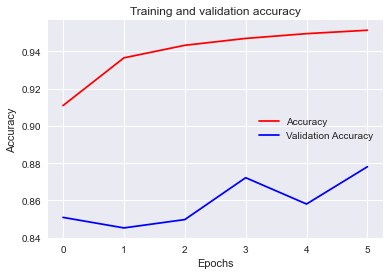

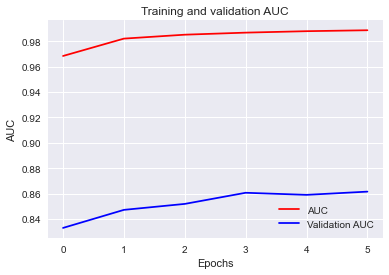

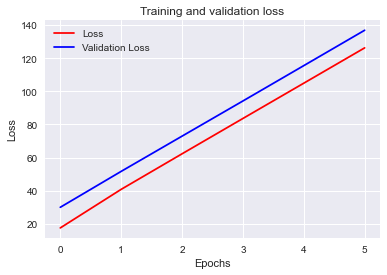

[status] Trial #1 training complete. Predicting new data ...


<Figure size 432x288 with 0 Axes>

In [6]:
from model import classify_document_concept_vectors
import matplotlib.pyplot as plt
%matplotlib inline

# Run the document-concept association classification
classify_document_concept_vectors(num_epochs=10, n_samples=None)

### Results

- With 100 hidden units in a simple three-layer DNN (including the input layer), the zero-shot text classifier reaches, approximately, an accuracy of 0.87 and AUC of 0.86. After a few episodes, we may start to observe signs of **overfitting** with a widening gap between the training and the validation accurcy; early stopping via a callback is a simple solution for mitigating overfitting.
   - Note that the model performance wouldn't be great if the document vector were not derived appropriately. For instance, it may be tempting to take the average across all word vectors regardless if they can be found in the pre-trained model (and assign a default vector for all OOVs, say, a zero vector). However, this would lead to a lower generalization capacity, in which case the best accuracy observed in the validation set is at approximately 0.61 and correspondingly, the best AUC observed in the validation set is at approximately 0.76 -- even though the model can still fit the training set at great accuracy
   - See `create_baseline()` and `create_baseline2()` in the module `model` for example DNNs

- To see if the proposed DNN works well in general, we could use - either another well-tested dataset (e.g. breast cancer data) or a synthetic dataset - to check if the DNN is capable of reaching a good performance. The anwswer is yes.
  - See `test_dnn()` in `model` for an example
- We could also examine if a classfical ML method can perform better than the proposed DNN on the document-concept vector. E.g. logistic regression for simple, linear decision boundary (potentially inducing a high-bias problem), or a random forest that generates more complex, non-linear decision boundaries. 
  - See `test_document_concept_vectors()` for an example
  - Better performance within classical ML methods has not been observed

### Additional Thoughts 

- To do list: In this demo, I did not evaluate the generalizability of the document-concept vectors on external data sets as did in the paper. Potentially, we could use HDBSCAN mentioned earlier to generate category trees.
- If clustering documents results in meaningful groups of topics (assuming that we have a good document vector representation), then adding the clustering information to the document-concept vector could potentially help for this zero-shot classification. The simplest method is to add cluster IDs as a new explanatory variable. 
- In the model evaluation, we could relex the "non-overlapping-concept constraint" to allow for shared concepts/keywords associated with the training and test splits. I expect that the classification performance will increase but this would be less meaningful as a model since it no longer accomplishes "zero shot" learning 